<a href="https://colab.research.google.com/github/errpv78/Scene-Depiction/blob/master/Flickr_8k_ImageCaptioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Captioning Model using Flickr 8K dataset

Dataset: https://www.kaggle.com/adityajn105/flickr8k

This dataset contains 8000 images each with 5 captions (as we have already seen in the Introduction section that an image can have multiple captions, all being relevant simultaneously).<br>


# 1. Downloading dataset

In [ ]:
# Connecting with google drive for Nist special dataset from kaggle
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Getting into kaggle folder
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle
%pwd

/content/gdrive/My Drive/Kaggle


'/content/gdrive/My Drive/Kaggle'

In [ ]:
%cd Image Captioning/Flickr8k

/content/gdrive/My Drive/Kaggle/Image Captioning/Flickr8k


In [ ]:
!pwd

/content/gdrive/My Drive/Kaggle/Image Captioning/Flickr8k


In [ ]:
# Downloading the data
!kaggle datasets download -d adityajn105/flickr8k
!ls

 99% 1.02G/1.04G [00:14<00:00, 82.0MB/s]
100% 1.04G/1.04G [00:14<00:00, 78.5MB/s]
flickr8k.zip


In [ ]:
# Unzip data: Int the drive
!unzip flickr8k.zip
!ls

In [ ]:
# Removing zipped file
!rm flickr8k.zip
!ls

captions.txt  Images


In [ ]:
# Importing Necessary Modules
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
import cv2
from google.colab.patches import cv2_imshow
from tqdm.notebook import tqdm
import random

# 2. Preprocessing captions

In [ ]:
# Opening captions file
filename = "captions.txt"
file = open(filename, 'r')
text = file.read()

In [ ]:
# No of captions
print(len(text.split('\n')))

# No of Images
!ls Images/ -1 | wc -l

40457
8091


In [ ]:
# Creating captions dictionary with image_name as key and list of captions as value
captions = dict()
for line in text.split('\n')[1:]:
    words = line.split(',')
    # print(words)
    try:
        image_id, image_caption = words[0], words[1:]

        image_id = image_id.split('.')[0]

        image_caption = ' '.join(image_caption)
        if image_id not in captions:
            captions[image_id] = []
        captions[image_id].append(image_caption)
    except:
        continue

# Removing unrequired instance
if '' in captions:
    captions.pop('')
    print("Removed")
# There is an unrequired instance in captions dict        

Removed


In [ ]:
print('No of images', len(captions)) # 8091 images

No of images 8091


In [ ]:
# Displaying image with given image id
def show_image(img_id):
    img_path = 'Images/'+img_id +'.jpg'
    img = cv2.imread(img_path)
    cv2_imshow(img)

['A brown and white dog is running through the snow .', 'A dog is running in the snow', 'A dog running through snow .', 'a white and brown dog is running through a snow covered field .', 'The white and brown dog is running over the surface of the snow .']


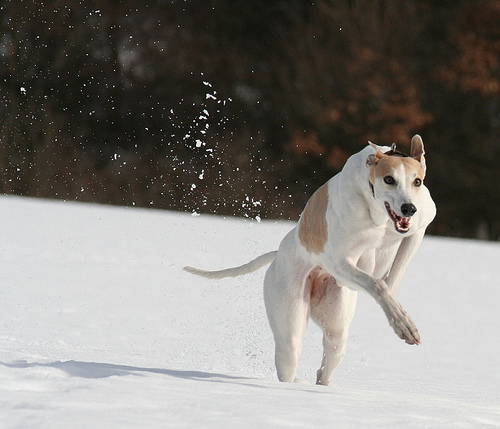

In [ ]:
# Captions of sample image id
img_id = '101654506_8eb26cfb60'
print(captions[img_id])
show_image(img_id)
# img.show()

In [ ]:
# Data cleaning: Removing {@,#,%..}; lowercasing; removing words less than 1 length;
# Removing words containing letters other than alphabets
translation_table = str.maketrans('', '', string.punctuation)
for img, cap_lst in tqdm(captions.items()):
    for i in range(len(cap_lst)):
        cap = cap_lst[i]    
        cap = cap.split()
        cap = [word.lower() for word in cap]
        cap = [word.translate(translation_table) for word in cap]
        cap = [word for word in cap if len(word)>1]
        cap = [word for word in cap if word.isalpha()]
        cap_lst[i] = ' '.join(cap)

In [ ]:
# Training and test split
split_ratio = 0.2
train_captions = dict()
test_captions = dict()
for i in captions:
    if random.random()>split_ratio:
        train_captions[i] = captions[i]
    else:
        test_captions[i] = captions[i]

In [ ]:
# Checking split
print("Training data:", len(train_captions))
print("Testing data:", len(test_captions))

Training data: 6472
Testing data: 1619


In [ ]:
# Saving train and test captions
def save_captions(captions, filename):
    lines = []
    for key, cap_lst in tqdm(captions.items()):
        for cap in cap_lst:
            lines.append(key + ' '+ cap)
        data = '\n'.join(lines)    
        file = open(filename, 'w')
        file.write(data)
        file.close()

save_captions(train_captions, 'train_captions.txt')
save_captions(test_captions, 'test_captions.txt')

In [ ]:
# Files
!ls

captions.txt  Images  test_captions.txt  train_captions.txt


In [ ]:
# Finding unique set of words in captions to form vocabulary
vocab = set()
for key in captions:
    [vocab.update(s.split()) for s in captions[key]]
print("Vocab Size: ", len(vocab))   # 

Vocab Size:  8763


# 3. Preprocesing images

In [ ]:
# Loading images
# Matching training captions to training images, and same for test
inputDirectory = 'Images/'
train_img = []
test_img = []
for filename in tqdm(os.listdir(inputDirectory)):
    if filename[:-4] in train_captions:
        train_img.append(filename)
    elif filename[:-4] in test_captions:
        test_img.append(filename)    
    else:
        print(filename)    

print(len(train_img), len(train_captions))
print(len(test_img), len(test_captions))


6472 6472
1619 1619


In [ ]:
# Making image compatible for InceptionV3 input
def load_preprocess_img(image_path):
    img_path = 'Images/'+image_path
    img = image.load_img(img_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [ ]:
# Downloading inceptionV3 model
model = InceptionV3(weights='imagenet')

96116736/96112376 [==============================] - 1s 0us/step


In [ ]:
# New model with last 2 layers removed
model_new = Model(model.input, model.layers[-2].output)

In [ ]:
# Encoding image as feature vectors
def encode(image):
    image = load_preprocess_img(image)
    feat_vect = model_new.predict(image)
    feat_vect = np.reshape(feat_vect, feat_vect.shape[1])
    return feat_vect

In [ ]:
# Encoding training data
encoding_train = {}
for img in tqdm(train_img):
    encoding_train[img[:-4]] = encode(img)
print(len(encoding_train))    


6472


In [ ]:
# Saving encoded images as pickle file
with open('encoded_train_images.pkl', 'wb') as encoded_pickle:
    dump(encoding_train, encoded_pickle)    

In [ ]:
# Encoding testing images
encoding_test = {}
for img in tqdm(test_img):
    encoding_test[img[7:-4]] = encode(img)

In [ ]:
# Saving encoded images as pickle file
with open('encoded_test_images.pkl', 'wb') as encoded_pickle:
    dump(encoding_test, encoded_pickle)

In [ ]:
!ls

captions.txt		 encoded_train_images.pkl  test_captions.txt
encoded_test_images.pkl  Images			   train_captions.txt


# M-1 Word Embeddings

In [ ]:
# Loading train data
train_images = load(open('encoded_train_images.pkl', 'rb'))
print('Training data: ', len(train_images))

def load_preprocess_captions(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()

    captions = dict()
    for line in text.split('\n'):
        tokens = line.split()
        image_name, image_cap = tokens[0], tokens[1:]
        if image_name not in captions:
            captions[image_name] = []
        cap = 'startseq ' + ' '.join(image_cap) + ' endseq'
        captions[image_name].append(cap)
    return captions

train_captions = load_preprocess_captions('train_captions.txt')        

Training data:  6465


In [ ]:
# Creating list of all captions
all_train_captions = []
for key, value in tqdm(train_captions.items()):
    for cap in value:
        all_train_captions.append(cap)
len(all_train_captions)

32325

In [ ]:
# Filtering words with frequency greater than equal to 10
words_count_threshold = 10
words = dict()
for i in tqdm(all_train_captions):
    for w in i.split(' '):
        if w not in words:
            words[w] = 1
        else:
            words[w] += 1

vocab = [w for w in words if words[w]>words_count_threshold]
print("Vocabulary: ", len(vocab))


Vocabulary:  1640


In [ ]:
# Creating word to ind and ind to word dictionary
wordtoind = dict()
indtoword = dict()
j = 1
for i in vocab:
    wordtoind[i] = j
    indtoword[j] = i
    j+=1

In [ ]:
# Additional 1 for padding 0's
vocab_size = len(wordtoind)+1

# Max length of caption
def to_lines(captions):
	cap = []
	for key in captions.keys():
		[cap.append(d) for d in captions[key]]
	return cap

def max_length(captions):
	lines = to_lines(captions)
	return max(len(d.split()) for d in lines)

# Determining maximum sequence length
max_length = max_length(train_captions)
print('Description Length: %d' % max_length)

Description Length: 34


In [ ]:
# Data Generator

# yield
"""yield is a keyword in Python that is used to return from a function without destroying the
 states of its local variable and when the function is called, the execution starts from the 
 last yield statement. Any function that contains a yield keyword is termed as generator. """
def data_generator(captions, images, wordtoind, max_length, batch_size):
    x1, x2, y = [], [], []
    n = 0

    while True:
        for key, cap_lst in captions.items():
            n+=1

            image = train_images[key]
            for cap in cap_lst:

                seq = [wordtoind[word] for word in cap.split(' ') if word in wordtoind]

                # Split one seq into multiple x, y pairs
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen = max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    x1.append(image)
                    x2.append(in_seq)
                    y.append(out_seq)

            if n==batch_size:
                yield [[array(x1), array(x2)], array(y)]
                x1, x2, y = [], [], []
                n=0

In [ ]:
# Loading glove file
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-10-05 10:58:32--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-10-05 10:58:32--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-10-05 10:58:33--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
!ls

captions.txt		  glove.6B.200d.txt  Images
encoded_test_images.pkl   glove.6B.300d.txt  test_captions.txt
encoded_train_images.pkl  glove.6B.50d.txt   train_captions.txt
glove.6B.100d.txt	  glove.6B.zip


In [ ]:
# Removing unrequired embeddings
!rm glove.6B.300d.txt
!rm glove.6B.100d.txt
!rm glove.6B.50d.txt
!rm glove.6B.zip

In [ ]:
# Loading enbeddings file
embeddings_index = dict()
f = open('glove.6B.200d.txt', encoding='utf-8')

for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()    
print('Number of word vectors.',len(embeddings_index))

Number of word vectors. 400000


In [ ]:
# Creating embedding matrix
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tqdm(wordtoind.items()):
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

(1641, 200)

# M-1 Model Definition and training

In [ ]:
# Defining Model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [ ]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 200)      328200      input_5[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 2048)         0           input_4[0][0]                    
_______________________________________________________________________________________

In [ ]:
model.layers[2]

In [ ]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False # No need to train the pretrained embedding layer
model.compile(loss='categorical_crossentropy', optimizer='adam', metric = ['accuracy'])

In [ ]:
epochs = 10
batch_size = 3
steps = len(train_captions)//batch_size

In [ ]:
for i in range(epochs):
    generator = data_generator(train_captions, train_images, wordtoind, max_length, batch_size)
    print(type(generator))
    print(generator)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_' + str(i) + '.h5')

<class 'generator'>
<generator object data_generator at 0x7f12da822ba0>


ValueError: ignored

# M-2 Start from loading captions and image features

In [ ]:
def load_preprocess_captions(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()

    captions = dict()
    for line in text.split('\n'):
        tokens = line.split()
        image_name, image_cap = tokens[0], tokens[1:]
        if image_name not in captions:
            captions[image_name] = []
        cap = 'startseq ' + ' '.join(image_cap) + ' endseq'
        captions[image_name].append(cap)
    return captions


# Load train data
train_features = load(open('encoded_train_images.pkl', 'rb'))
print('Training images: ', len(train_features))

train_captions = load_preprocess_captions('train_captions.txt')   
print("Training captions: ", len(train_captions))     

# Load test data
test_features = load(open('encoded_test_images.pkl', 'rb'))
print('Testing images: ', len(test_features))

test_captions = load_preprocess_captions('test_captions.txt')   
print("Testing captions: ", len(test_captions))     

Training images:  6465
Training captions:  6465
Testing images:  1626
Testing captions:  1626


In [ ]:
print(train_features['1433577867_39a1510c43'].shape)

(2048,)


In [ ]:
# Creating list of all captions
all_train_captions = []
for key, value in train_captions.items():
    for cap in value:
        all_train_captions.append(cap)
print(len(all_train_captions))
max_length = max(len(d.split()) for d in all_train_captions)
print("Maximum caption length: ", max_length)

# Fitting tokenizer
def create_tokenizer(all_train_captions):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(all_train_captions)
    return tokenizer

tokenizer = create_tokenizer(all_train_captions)
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size: ", vocab_size)

32325
Maximum caption length:  34
Vocabulary Size:  7934


In [ ]:
# Create training sequences
def generate_sequences1(tokenizer, max_length, captions, images, vocab_size):
    x1, x2, y = [], [], []
    n = 0
    for key, cap_lst in captions.items():
        n+=1
        image = images[key]
        for cap in cap_lst:

            seq = tokenizer.texts_to_sequences([cap])[0]

            # Split one seq into multiple x, y pairs
            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                in_seq = pad_sequences([in_seq], maxlen = max_length)[0]
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                x1.append(image)
                x2.append(in_seq)
                y.append(out_seq)
    return array(x1), array(x2), array(y)


def generate_sequences2(tokenizer, max_length, captions, images, vocab_size):
    x1, x2, y = [], [], []
    n = 0
    for key, cap_lst in captions.items():
        n+=1
        image = images[key]
        for cap in cap_lst:

            seq = tokenizer.texts_to_sequences([cap])[0]

            # Split one seq into multiple x, y pairs
            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                in_seq = pad_sequences([in_seq], maxlen = max_length)[0]
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                x1.append(image)
                x2.append(in_seq)
                y.append(out_seq)
    return array(x1), array(x2), array(y)

In [ ]:
# define the captioning model
def define_model(vocab_size, max_length):

	inputs1 = Input(shape=(2048,))
	fe1 = Dropout(0.5)(inputs1)
	fe2 = Dense(256, activation='relu')(fe1)
 
	# sequence model
	inputs2 = Input(shape=(max_length,))
	se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
	se2 = Dropout(0.5)(se1)
	se3 = LSTM(256)(se2)

	# decoder model
	decoder1 = add([fe2, se3])
	decoder2 = Dense(256, activation='relu')(decoder1)
	outputs = Dense(vocab_size, activation='softmax')(decoder2)

	# tie it together [image, seq] [word]
	model = Model(inputs=[inputs1, inputs2], outputs=outputs)
	model.compile(loss='categorical_crossentropy', optimizer='adam')

	# summarize model
	print(model.summary())
	return model

model = define_model(vocab_size, max_length)

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 34, 256)      2031104     input_11[0][0]                   
__________________________________________________________________________________________________
dropout_8 (Dropout)             (None, 2048)         0           input_10[0][0]                   
______________________________________________________________________________________

In [ ]:
# Checkpoint callbacks
filepath = 'model/model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [ ]:
# Run with 500 train images
x1_train, x2_train, y_train = generate_sequences1(tokenizer, max_length, train_captions, train_features, vocab_size)
x1_test, x2_test, y_test = generate_sequences2(tokenizer, max_length, test_captions, test_features, vocab_size)

In [ ]:
# fit model
model.fit([x1_train, x2_train], y_train, epochs=20, verbose=2, callbacks=[checkpoint], validation_data=([x1_test, x2_test], y_test))

NameError: ignored

In [ ]:

# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

# generate a description for an image
def generate_desc(model, tokenizer, image, max_length):

	# seed the generation process
	in_text = 'startseq'

	# iterate over the whole length of the sequence
	for i in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
		yhat = model.predict([image,sequence], verbose=0)
		# convert probability to integer
		yhat = argmax(yhat)
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
	return in_text

def evaluate_model(model, captions, images, tokenizer, max_length):
	actual, predicted = list(), list()
	# step over the whole set
	for key, cap_list in captions.items():
		# generate description
		yhat = generate_desc(model, tokenizer, images[key], max_length)
		# store actual and predicted
		references = [d.split() for d in cap_list]
		actual.append(references)
		predicted.append(yhat.split())
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

# M-3 Training with Progressive loading (to avoid memory issues)

In [ ]:
# Create training sequences
def generate_sequences(tokenizer, max_length, cap_lst, image, vocab_size):
    x1, x2, y = [], [], []
    print(image.shape)

    for cap in cap_lst:
        seq = tokenizer.texts_to_sequences([cap])[0]

        # Split one seq into multiple x, y pairs
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen = max_length)[0]
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

            x1.append(image)
            x2.append(in_seq)
            y.append(out_seq)

    return array(x1), array(x2), array(y)

# data generator, intended to be used in a call to model.fit_generator()
def data_generator(captions, images, tokenizer, max_length, vocab_size):
	# loop for ever over images
    while 1:
        for key, cap_list in captions.items():
            image = images[key]
            print(image.shape)
            in_img, in_seq, out_word = generate_sequences(tokenizer, max_length, cap_list, image, vocab_size)
            yield [[in_img, in_seq], out_word]

In [ ]:
# fit model
epochs = 20
steps = len(train_captions)
for i in range(epochs):
    generator = data_generator(train_captions, train_features, tokenizer, max_length, vocab_size)
    model.fit(generator, epochs=1, verbose=1, steps_per_epoch=steps)
    model.save('Model/model_'+str(i)+'.h5')

(2048,)
(2048,)


ValueError: ignored